In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from my_modules import custom_f1_score
import re
import nltk
from nltk.corpus import stopwords
from collections import Counter


In [3]:
# Get the list of stopwords
nltk.download('stopwords')
stopwords_list = set(stopwords.words('english'))

dataset = pd.read_csv("data/training_data.tsv.gz", sep="\t", header=None)
dataset.dropna(inplace=True)

[nltk_data] Downloading package stopwords to C:\Users\Konstantinos
[nltk_data]     Razgkel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


C:\Users\Konstantinos Razgkel\AppData\Local\Temp\ipykernel_9720\3633480928.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={0: 'index', 1: 'title', 2: 'text', 3: 'labels'}, inplace=True)
C:\Users\Konstantinos Razgkel\AppData\Local\Temp\ipykernel_9720\3633480928.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('index', axis=1, inplace=True)
C:\Users\Konstantinos Razgkel\PycharmProjects\DataMine\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

Cluster 13: ['html,css', 'css', 'css', 'html,css', 'html', 'javascript', 'javascript,css', 'javascript']
Cluster 10: ['javascript', 'javascript,jquery,css', 'javascript', 'javascript', 'javascript,jquery', 'javascript', 'javascript', 'javascript,jquery', 'javascript,jquery', 'javascript', 'jquery']
Cluster 14: ['javascript', 'javascript,html', 'html', 'javascript', 'css', 'javascript,css', 'javascript', 'javascript,html,css', 'html', 'javascript', 'javascript,html', 'html', 'html', 'javascript,html', 'html', 'html', 'javascript', 'javascript', 'javascript', 'javascript,jquery,html']
Cluster 6: ['javascript', 'javascript,html', 'jquery', 'javascript', 'javascript', 'javascript', 'javascript', 'javascript', 'jquery', 'javascript', 'javascript,jquery', 'jquery', 'javascript', 'jquery', 'javascript,html', 'javascript', 'jquery']
Cluster 12: ['javascript', 'javascript,jquery', 'javascript,jquery', 'javascript', 'javascript,html', 'jquery', 'javascript', 'javascript,html', 'javascript', 'jav

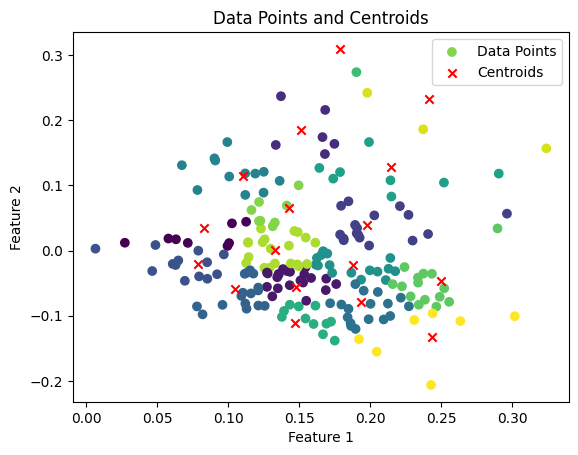

AttributeError: 'Series' object has no attribute 'columns'

In [5]:
df = dataset.head(1000)

df.rename(columns={0: 'index', 1: 'title', 2: 'text', 3: 'labels'}, inplace=True)
df.drop('index', axis=1, inplace=True)

# Get the features
X  = df.drop('labels', axis=1)

# Start preprocessing the data
# We Lower case all the data
# we remove all stop words (the, a, etc)
# We remove other words that are from html (e.g <div><!div>)
X = X.applymap(lambda x: re.sub(r'<.*?>|[^\w\s]', '', x.lower())).applymap(lambda x: ' '.join([word for word in x.split() if word not in stopwords_list]))

# We want to get all the unique labels
unique_labels = df['labels'].unique()
n_clusters = len(unique_labels)


# We will now conca title and text into one dataset
X = X["title"] + X["text"]
y = df['labels']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

prediction_stored_data = pd.DataFrame(X_test).copy()

# Initialize the TfidfVectorizer - we normalize the text into numerical values
vectorizer = TfidfVectorizer()
pca = TruncatedSVD(n_components=2)

# Fit and transform the text data and apply dimensionality reduction
X_train = pca.fit_transform(vectorizer.fit_transform(X_train))
X_test = pca.transform(vectorizer.transform(X_test))

# Initialize the KNN classifier
kmeans = KMeans(n_clusters=n_clusters)

# Train the KNN classifier
kmeans.fit(X_train, y_train)

centroids = kmeans.cluster_centers_

# Make predictions on the test set
y_pred = kmeans.predict(X_test)

# Create a dictionary to store the assigned cluster for each label
label_cluster_dict = {}

# Iterate over the predicted cluster labels and original labels
for cluster_label, original_label in zip(y_pred, y_test):
    if cluster_label not in label_cluster_dict:
        # Create a new entry in the dictionary for the cluster label
        label_cluster_dict[cluster_label] = []

    # Append the original label to the cluster label entry
    label_cluster_dict[cluster_label].append(original_label)

# Print the assigned labels for each cluster
for cluster_label, original_labels in label_cluster_dict.items():
    print(f"Cluster {cluster_label}: {original_labels}")

# Plot the data points and centroids
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', c='red')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Data Points and Centroids')
plt.legend(['Data Points', 'Centroids'])

# Show the plot
plt.show()
# Make predictions on the test set
y_pred = kmeans.predict(X_test)

# Make the dataframes
prediction_df = pd.DataFrame(y_pred, columns=y.columns)
prediction_df.reset_index(drop=True, inplace=True)

prediction_stored_data.reset_index(drop=True, inplace=True)

custom_f1_score = custom_f1_score(y_test, y_pred)
print(f"The F1-score of our problem is {custom_f1_score}")

# The unknown data with the prediction
final_results = pd.concat([prediction_stored_data, prediction_df], axis=1)
final_results


In [8]:
y_test

800           html,css
801         javascript
802         javascript
803         javascript
804    javascript,html
            ...       
995             jquery
996                css
997         javascript
998             jquery
999             jquery
Name: labels, Length: 200, dtype: object